# Team ID : PNT2022TMID08579
Project Name:  Crude Oil Price Prediction

# DATA PREPROCESSING


## Importing the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='exaUEAqwp406Yxi85US4ZsR0_2q9_4iBMrDAX_uWZTe9',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'crudemodeldeployment-donotdelete-pr-gvzcfk2wfoglsp'
object_key = 'Crude Oil Prices Daily.xlsx'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']

data = pd.read_excel(body.read())
data.head()


,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [6]:
data.head()

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


## Handling missing values

In [7]:
data.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [8]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [9]:
data.dropna(axis=0,inplace=True)

In [10]:
data_oil=data.reset_index()['Closing Value']

In [11]:
data_oil

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

In [12]:
data.isnull().any()

Date             False
Closing Value    False
dtype: bool

## Feature Scaling 

In [13]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler(feature_range=(0,1))
data_oil=scalar.fit_transform(np.array(data_oil).reshape(-1,1))


## Data Visualization

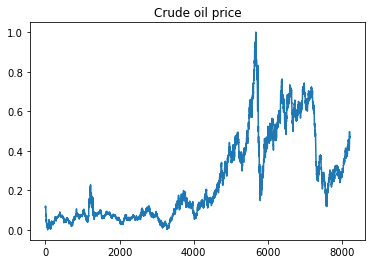

In [14]:
plt.title('Crude oil price')
plt.plot(data_oil)

## Splitting data into Train and Test Data

In [15]:
training_size=int(len(data_oil)*0.65)
test_size=len(data_oil)-training_size
train_data,test_data=data_oil[0:training_size,:],data_oil[training_size:len(data_oil),:1]

In [16]:
training_size,test_size

(5340, 2876)

In [17]:
train_data.shape

(5340, 1)

## Creating a dataset with sliding windows

In [18]:
def create_dataset (dataset, time_step=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-time_step-1):

        a = dataset[i:(i+time_step), 0] 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX),np.array(dataY)

In [19]:
time_step = 10

X_train, y_train=create_dataset(train_data,time_step)

X_test, y_test = create_dataset(test_data,time_step)

In [20]:
print(X_train.shape),print(y_train.shape)

(5329, 10)
(5329,)


(None, None)

In [21]:
print(X_test.shape),print(y_test.shape)

(2865, 10)
(2865,)


(None, None)

In [22]:
X_train

array([[0.11335703, 0.11661484, 0.12053902, ..., 0.10980305, 0.1089886 ,
        0.11054346],
       [0.11661484, 0.12053902, 0.11550422, ..., 0.1089886 , 0.11054346,
        0.10165852],
       [0.12053902, 0.11550422, 0.1156523 , ..., 0.11054346, 0.10165852,
        0.09906708],
       ...,
       [0.36731823, 0.35176958, 0.36080261, ..., 0.36391234, 0.37042796,
        0.37042796],
       [0.35176958, 0.36080261, 0.35354657, ..., 0.37042796, 0.37042796,
        0.37879461],
       [0.36080261, 0.35354657, 0.35295424, ..., 0.37042796, 0.37879461,
        0.37916482]])

In [23]:
X_train.shape

(5329, 10)

In [24]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

# MODEL BUILDING

# Importing the model building libraries

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Initializing the model

In [26]:
model=Sequential()

# Adding LSTM Layers

In [27]:
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))

# Adding Output Layers

In [28]:
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


# Configure The Learning Process

In [29]:
model.compile(loss='mean_squared_error',optimizer='adam')

# Train The Model

In [30]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
84/84 [==============================] - 6s 31ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 2/10
84/84 [==============================] - 2s 19ms/step - loss: 1.2657e-04 - val_loss: 7.7213e-04
Epoch 3/10
84/84 [==============================] - 2s 18ms/step - loss: 1.2707e-04 - val_loss: 8.7708e-04
Epoch 4/10
84/84 [==============================] - 2s 18ms/step - loss: 1.2473e-04 - val_loss: 8.7773e-04
Epoch 5/10
84/84 [==============================] - 2s 21ms/step - loss: 1.2389e-04 - val_loss: 7.9669e-04
Epoch 6/10
84/84 [==============================] - 2s 21ms/step - loss: 1.2645e-04 - val_loss: 0.0013
Epoch 7/10
84/84 [==============================] - 2s 20ms/step - loss: 1.2189e-04 - val_loss: 8.6889e-04
Epoch 8/10
84/84 [==============================] - 2s 21ms/step - loss: 1.2366e-04 - val_loss: 8.4587e-04
Epoch 9/10
84/84 [==============================] - 2s 18ms/step - loss: 1.2641e-04 - val_loss: 0.0017
Epoch 10/10
84/84 [==============================] - 

# Model Evaluation

In [32]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [33]:
train_predict=scalar.inverse_transform(train_predict)
test_predict=scalar.inverse_transform(test_predict)

In [34]:
import math
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_train,train_predict))

28.729210671681734

# Save The Model

In [35]:
from tensorflow.keras.models import load_model
model.save("crudeoilprediction.h5")

# Test The Model

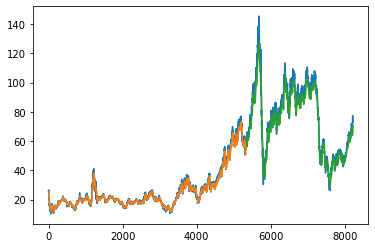

In [36]:
look_back= 10

trainPredictPlot = np.empty_like(data_oil) 

trainPredictPlot[:, :]= np.nan

trainPredictPlot[look_back:len(train_predict)+look_back, :]= train_predict

testPredictPlot =np.empty_like(data_oil)

testPredictPlot[:, :]= np.nan

testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_oil)-1, :]= test_predict 
                 

plt.plot(scalar.inverse_transform(data_oil))

plt.plot(trainPredictPlot) 
plt.plot(testPredictPlot)
plt.show()

In [37]:
len(test_data)

2876

In [38]:
x_input=test_data[2866:].reshape(1,-1)
x_input.shape

(1, 10)

In [39]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [40]:
lst_output=[]
n_steps=10
i=0
while(i<10):
    if(len(temp_input)>10):

#print(temp input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))

        x_input=x_input.reshape(1,-1)

        x_input=x_input.reshape((1, n_steps, 1))

        #print(x_input)

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:] 
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        
print (lst_output) 

[0.45424235]
11
1 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.45424235]
1 day output [[0.4557456]]
2 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.45424235 0.45574561]
2 day output [[0.453553]]
3 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.45424235 0.45574561 0.45355299]
3 day output [[0.4498857]]
4 day input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.45424235 0.45574561 0.45355299 0.4498857 ]
4 day output [[0.44822255]]
5 day input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.45424235
 0.45574561 0.45355299 0.4498857  0.44822255]
5 day output [[0.44580066]]
6 day input [0.47341922 0.46497853 0.47038353 0.47149415 0.45424235 0.45574561
 0.45355299 0.4498857  0.44822255 0.44580066]
6 day output [[0.44324726]]
7 day input [0.46497853 0.47038353 0.47149415 0.45424235 0.45574561 0.

In [41]:
day_new=np.arange(1,11)
day_pred=np.arange(11,21)

In [42]:
len(data_oil)

8216

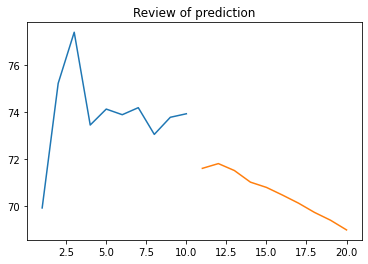

In [43]:
plt.plot(day_new,scalar.inverse_transform(data_oil[8206:]))
plt.title("Review of prediction")
plt.plot(day_pred,scalar.inverse_transform(lst_output))
plt.show()

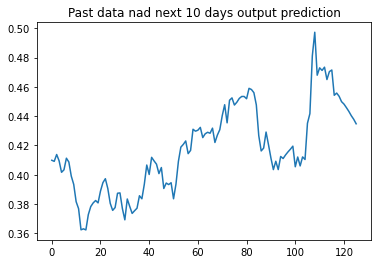

In [44]:
df3=data_oil.tolist()
df3.extend(lst_output)
plt.title("Past data nad next 10 days output prediction")
plt.plot(df3[8100:])

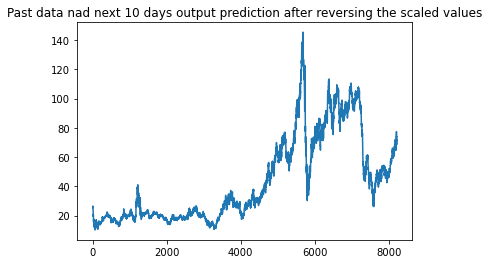

In [45]:
df3=scalar.inverse_transform(df3).tolist()
plt.title("Past data nad next 10 days output prediction after reversing the scaled values")
plt.plot(df3)

In [87]:
!pip install ibm_watson_machine_learning --upgrade

In [47]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
                    "url": "https://us-south.ml.cloud.ibm.com",
                    "apikey":"qBVjfLpxSGroBr5cd8BNRjoC3pZhoHyrC9bKxMZ1IePl"
                   }
client = APIClient(wml_credentials)

In [48]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    #print(space)
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [49]:
space_uid = guid_from_space_name(client, 'models')
print("Space UID = " + space_uid)

Space UID = 94d78c87-c019-434a-8fb6-69c9924eaf5f


In [50]:
client.set.default_space(space_uid)

'SUCCESS'

In [51]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [52]:
software_space_uid=client.software_specifications.get_uid_by_name('tensorflow_rt22.1-py3.9')
software_space_uid


'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [75]:
model_result_path = "crudeoilprediction.h5"
model.save(model_result_path)

In [77]:
!tar -zcvf crudeoilprediction.tgz crudeoilprediction.h5

crudeoilprediction.h5


In [78]:
metadata = {
    client.repository.ModelMetaNames.NAME:" CNN Model Building",
    client.repository.ModelMetaNames.TYPE:'tensorflow_2.7',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
}

In [79]:
model_details=client.repository.store_model(model=model,meta_props={
    client.repository.ModelMetaNames.NAME:" CNN Model Building",
    client.repository.ModelMetaNames.TYPE:'tensorflow_2.7',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
})

Saving the tensorflow model requires the model of either tf format or h5 format for Sequential model.
Publishing model failed.
Reason: Saving the tensorflow model requires the model of either tf format or h5 format for Sequential model.


WMLClientError: Publishing model failed.
Reason: Saving the tensorflow model requires the model of either tf format or h5 format for Sequential model.

In [83]:
model_id=client.repository.get_model_id(metadata)

KeyError: 'metadata'

In [80]:
published_model = client.repository.store_model(model= '/home/wsuser/work/crudeoilprediction.tgz', meta_props=metadata, training_data= X_train,training_target= y_train)

In [89]:
model_id = published_model["metadata"]["guid"]

model_deployment_details = client.deployments.create(artifact_uid=model_id, name="models" )

KeyError: 'guid'

In [68]:
/home/wsuser/work/crudeoilprediction.h5

NameError: name 'home' is not defined

In [71]:
cd home

[Errno 2] No such file or directory: 'home'
/home/wsuser/work


In [72]:
cd..

SyntaxError: invalid syntax (223093403.py, line 1)

In [81]:
ls

crudeoilprediction.h5  crudeoilprediction.tgz  keras_model.tgz
